# Getting Started

This document describes how to generate and use the members from the family of least-misfit gridding functions. In particular, it will describe how they can be evaluated at arbitrary points for incorporation into existing mapping programs which support convolutional gridding. Subsequent notebooks will describe the algorithms for generating and analyzing the properties of these and other gridding functions in more detail.

The Python programs used to do the calculations are in the file `algorithms\core.py` relative to the directory containing these notebooks. Each function has a docstring that describes its purpose, the input arguments and the return values.

## Coordinate Systems in Visibility and Map Spaces

In theoretical discussions of radio-astronomical mapping, it is usual to start with visibility coordinates $(u,v,w)$ measured in multiples of the wavelength and direction cosines $(l,m,n)$ on the celestial sphere. The visibilities $\mathcal{V}$ are then related to the sky brightness $I(l,m)$ via an integral over the visible portion of the sphere via
\[ \mathcal{V}(u,v,w) = \int\int \frac{I(l,m)}{n}  \exp\left[-\mathrm{i}2\pi\left(ul + vm + w(n-1)\right)\right] \,\mathrm{d}l\,\mathrm{d}m\]
where $k^2+l^2+n^2=1$. For narrow-field observations close to the phase center $(l,m,n) \approx (0,0,1),$ we obtain the two-dimensional Fourier transform
\[ \mathcal{V}(u,v) = \int\int I(l,m)  \exp\left[-\mathrm{i}2\pi\left(ul + vm\right)\right] \,\mathrm{d}l\,\mathrm{d}m\]
The inverse Fourier transform recovers the sky brightness from the visibilities:
\[ I(l,m) =  \int\int \mathcal{V}(u,v)  \exp\left[\mathrm{i}2\pi\left(ul + vm\right)\right] \,\mathrm{d}u\,\mathrm{d}v\]
When mapping a small portion of the sky, say $-L/2\leq l\leq L/2, -M/2\leq m\leq M/2$ it is convenient to introduce normalized map coordinates $(x,y)$ defined by $x=l/L, y=m/M$ which each range from $-\frac{1}{2}$ to $\frac{1}{2}$. Writing $u'=uL$ and $v'=vM$, we find
\[ I(x,y) \propto  \int\int \mathcal{V}(u',v')  \exp\left[\mathrm{i}2\pi\left(u'x + v'y\right)\right] \,\mathrm{d}u'\,\mathrm{d}v'\]
When processing a set of observations, the visibilities are measured on a finite set of baselines $\{(u_i,v_i)\}$ and we define the dirty map and beam by
\[ D(x,y) = \sum_i w_i\mathcal{V}(u'_i,v'_i)  \exp\left[\mathrm{i}2\pi\left(u'_ix + v'_iy\right)\right] \]
\[ B(x,y) = \sum_i w_i\exp\left[\mathrm{i}2\pi\left(u'_ix + v'_iy\right)\right] \]
where $w_i$ are a set of non-negative weights which add to one. The goal is to compute the direct Fourier transforms (DFT) prescribed in these definitions as the dirty map and beam are the starting points for further image reconstruction.

## Convolutional Gridding
In order to compute these transforms efficiently, the fast Fourier transform (FFT) algorithm is used, but this requires that both the visibilities and map intensities be sampled on regular rectangular grids. If we use an even number of points $N$ in each direction, the dirty map is computed using with the help of an (inverse) FFT via
\[ D\left(\frac{p}{N},\frac{q}{N}\right) = \left\{\sum_r\sum_s (K * \overline{\mathcal{V}})(r,s)\exp\left[\mathrm{i}\frac{2\pi(rp+sq)}{N}\right] \right\} H\left(\frac{p}{N},\frac{q}{N}\right) \]
where each of the indices $p, q, r$ and $s$ range over integer values from $-N/2$ through $N/2-1$. In convolutional gridding, the quantity $(K * \overline{\mathcal{V}})(r,s)$ whose FFT is being computed is given by
\[(K * \overline{\mathcal{V}})(r,s) = \sum_i K(r-u'_i, s-v'_i)\overline{\mathcal{V}}(u'_i,v'_i)\]
where $\overline{\mathcal{V}}(u'_i,v'_i) = w_i\mathcal{V}(u'_i,v'_i)$ are the weighted visibilities and $K$ is called the convolutional gridding kernel. $K$ is usually taken to be separable and of finite support. i.e., we assume that
we can write $K$ in terms of a function $C$ of one variable which vanishes outside the interval $[-W/2,W/2]$ such that
\[K(r-u'_i, s-v'_i) = C(r-u'_i) C(s-v'_i)\]
The quantity $W$ is an integer called the width of the gridding function $C$.

In practice, calcuation of $(K * \overline{\mathcal{V}})(r,s)$ is carried out by accumulating values in an $N\times N$ array. A (weighted) visibility point $w_i\mathcal{V}(u'_i, v'_i)$ affects $W^2$ elements in the array whose (integer) indices $(r,s)$ satisfy $|r-u'_i|< W/2$ and $|s-v'_i|<W/2$. Gridding the visibility into the array involves computing (or looking up) the $2W$ values $C(r-u'_i)$ and $C(s-v'_i)$ so that the two dimensional kernel $K(r-u'_i, s-v'_i)$ may be found. Once all visibility points have been processed, the FFT of the array may be found.

After calculating the FFT, the result is multiplied by a gridding correction function $H\left(\frac{p}{N},\frac{q}{N}\right)$ which may be factorized into the separable product $h\left(\frac{p}{N}\right)h\left(\frac{q}{N}\right)$ if a separable kernel $K$ is used. The least misfit functions described here are a prescription for finding the functions $C$ and $h$ so as to minimize the error associated with approximating the direct Fourier transform by the fast Fourier transform over the central portion of the map.

## Calculating the Least-Misfit Gridding Functions

Since are assuming that the convolution function is separable, it is convenient to work in one dimension for simplicity. The dirty map is given by the direct Fourier transform:

\[ D_{\text{DFT}}(x) = \sum_i w_i\mathcal{V}(u_i)  \exp\left[\mathrm{i}2\pi\left(u_ix\right)\right] \label{dft}\]

Since the dirty beam is computed in essentially the same way, replacing each $\mathcal{V}(u_i)$ by one, we shall no longer mention it explicitly.

This is to be approximated using an $N$ point FFT at the points $x_p=p/N$ for $p\in\{-N/2,...,N/2-1\}$. We have also dropped the prime from the visibility coordinate $u_i$, which is assumed to be scaled so as to take on integer values at the gridpoints of the FFT. The approximate dirty map is

\[ D_{\text{FFT}}(p/N) = h(p/N)\sum_{r=-N/2}^{N/2-1} G_r\exp\left(\mathrm{i}\frac{2\pi rp}{N}\right) \label{fft} \]

where the gridded visibilities $G_r$ are given by

\[G_r = (C * \overline{\mathcal{V}})(r) = \sum_i C(r-u_i)w_i{\mathcal{V}}(u_i)\]

Since $C$ is zero only outside the interval $[-W/2, W/2]$, the visibility at $u_i$ affects only $W$ values of $r$. The least-misfit gridding functions provide a way of minimizing the difference between the map calculated via the direct Fourier transform (\ref{dft}) and via the fast Fourier transform (\ref{fft}), where the difference is considered over the central portion of the map $|x|\leq x_0$ for some $x_0\leq\frac{1}{2}$.

We specify the desired values of $W$ (the **width**) and $x_0$ (the **optimization region**) when generating a gridding function. For a given value of $x_0,$ the optimization procedure calculates a solution starting with a width of $1$ and proceeds to successively larger widths until the desired value of $W$ is reached. The routine `find_opt_func` calculates the gridding correction function $h(x)$ on a collection of $N$ points on the interval $(0,x_0]$ and calculates $C$ on a collection of $MW$ points when performing the optimization. We find that using $M=32$ and $N=128$ is adequate for performing the optimization. After the optimization is complete, it will be possible to evaluate the gridding convolution and correction inexpensively on much finer grids.

The following cell illustrates performing the optimization for $x_0=0.25$ and for values of $W$ up to $7$. The result of each optimization is saved in a special object of type `OptFunc` for subsequent use. 

In [1]:
# Imports needed for notebook
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pickle

from algorithms.core import find_opt_func, make_lookup_table, get_grid_weights, get_grid_correction, get_gridder

In [ ]:
x0 = 0.25
M = 32
N = 128

opt_funcs = {}
for W in range(1, 8):
    # The initial guess for h (the gridding correction)
    #  is a constant for W<=3, and is based on the solutions
    #  for lower values of W once W>3
    if W <= 3:
        h_initial = np.ones(N)
    else:
        h_initial = opt_funcs[W-1].h * (opt_funcs[W-1].h/opt_funcs[W-2].h)
    # Perform the optimization for width W, placing the result in opt_funcs[W]
    opt_funcs[W] = find_opt_func(W, x0, N, M, h_initial)

# Save the results in a pickle file
with open("min_misfit_gridding_7.pkl", "wb") as pp:
    pickle.dump(opt_funcs, pp, protocol=-1)

Having calculated the optimal functions once and stored them in the pickle file, we can retrieve the results from the pickle file for the subsequent calculations making it no longer necessary to re-run the optimization unless `x0` is changed. In the following cell, we examine the optimization result for $W=7$

In [2]:
with open("min_misfit_gridding_7.pkl", "rb") as pp:
    opt_funcs = pickle.load(pp)

print(opt_funcs[7])

OptFunc(W=7, x0=0.25, h=array([1.00005678, 1.00022713, 1.00051111, 1.00090884, 1.00142044,
       1.00204611, 1.00278608, 1.00364061, 1.00461001, 1.00569463,
       1.00689487, 1.00821116, 1.00964399, 1.01119386, 1.01286136,
       1.01464709, 1.01655169, 1.01857587, 1.02072038, 1.02298599,
       1.02537354, 1.02788392, 1.03051804, 1.03327689, 1.03616148,
       1.0391729 , 1.04231225, 1.04558072, 1.04897952, 1.05250994,
       1.05617329, 1.05997097, 1.0639044 , 1.06797509, 1.07218457,
       1.07653447, 1.08102643, 1.08566219, 1.09044354, 1.09537232,
       1.10045044, 1.10567989, 1.1110627 , 1.11660098, 1.12229693,
       1.12815278, 1.13417086, 1.14035358, 1.14670339, 1.15322286,
       1.1599146 , 1.16678134, 1.17382587, 1.18105106, 1.18845988,
       1.19605539, 1.20384073, 1.21181914, 1.21999397, 1.22836864,
       1.2369467 , 1.24573178, 1.25472764, 1.26393813, 1.27336723,
       1.28301901, 1.29289769, 1.3030076 , 1.31335318, 1.32393902,
       1.33476984, 1.34585048, 1.35718

The primary result of the optimization is the gridding correction function calculated on the $N=128$ points between $0$ and $x_0$. The values of $W,$ $x_0$ and $M$ used in the optimization are included as well.

In order to use this for gridding, we need to take a (weighted) visibility at location $u_i$ and to calculate $C(r-u_i)$ for the $W$ values of $r$ around $u_i$. We can do this efficiently by a combination of table lookup and interpolation. These are done using the functions `make_lookup_table` and `get_grid_weights`. The `make_lookup_table` is run once. The integer `Ms` specifies the number of points per unit interval of $u$ at which the gridding convolution function is computed. Since the support is of width $W$ and the function is even, the number of points at which $C$ is computed is approximately $WM_s/2$. We also specify the degree $d$ of polynomial interpolation that is to be performed when the weights are calculated. For efficiency, we calculate one set of finite differences per degree of interpolation, so the total storage required is approximately $(d+1) W M_s/2$ reals. As discussed in the paper, for $W=7$ and $x_0=0.25$, using $M_s=64$ and $d=3$ gives results indistinguishable from exact evaluation of the gridding function.

In [3]:
opt_func = opt_funcs[7]
lookup = make_lookup_table(opt_func, Ms=64, degree=3)

We also need to calculate the gridding correction function on the grid of points at which the FFT based map is evaluated, namely $p/N$ for $p=-N/2,...,N/2-1$ although those points with $|p/N|\geq x_0$ would normally be discarded. This is done using the function `get_grid_correction` which can be used to find the correction function at any values of $x$. This will also normally be run once.

In [4]:
N = 2048
x = np.arange(-N/2, N/2)/N
correction = get_grid_correction(opt_func, x)

## Mapping using synthetic data

Consider an illustrative example in which $10000$ visibilities are gridded onto a one-dimensional grid of size $N=2048$. We compute the dirty map using both the DFT and using convolutional gridding with the least-misfit gridding function and the FFT.
The visibility data can be calculated for a collection of simulated sources, or by using a random set of complex numbers.

In [5]:
# Function for synthesizing visibility data at u from a sky consisting 
#  of random point sources with specified fluxes and locations
def mock_vis(u, fluxes, locs):
    V = np.zeros(u.shape, dtype=complex)
    for flux, loc in zip(fluxes, locs):
        V += flux * np.exp(-1j*2*np.pi*loc*u)
    return V

In [6]:
# Generate visibility data
N = 2048
Nvis = 10000
# Nsrc = 20
fluxes = [1.0, 2.0]  # np.random.exponential(1.0, Nsrc) 
locs = [0.0, 0.125]  # np.random.uniform(-0.5, 0.5, Nsrc)
u = np.random.uniform(-N/2+50, N/2-50, Nvis)
V = mock_vis(u, fluxes, locs)

# Uncomment following line for randomly generated visibilities
# V = np.random.randn(u.shape) + 1j*np.random.randn(u.shape)

# After executing the definition for the "adversarial_vis" function given
#  below, uncomment following line for visibilities that give largest
#  possible error at x=0
# V = adversarial_vis(u)

In [7]:
# Generate a set of weights which add up to one
w = np.ones(Nvis)
# w = np.random.uniform(0.0, 1.0, Nvis)
w = w/sum(w)

In [8]:
# Calculate the dirty map using a DFT
D_DFT = 0
for i in range(Nvis):
    D_DFT = D_DFT + np.real(w[i] * V[i] * np.exp(1j*2*np.pi*u[i]*x))

In [9]:
# Calculate the dirty map using gridding, FFT followed by grid correction
G = np.zeros(N, dtype=complex)
for i in range(Nvis):
    locations, conv_func = get_grid_weights(lookup, u[i])
    # Values of u in G range from -N/2 to N/2-1. Thus the
    #  index corresponding to u is u+N//2
    G[locations + N//2] += w[i] * V[i] * conv_func
# The inverse FFT in numpy is defined with a 1/N prefactor
D_FFT = N*np.real(correction * np.fft.fftshift(np.fft.ifft(np.fft.fftshift(G))))

<IPython.core.display.Javascript object>


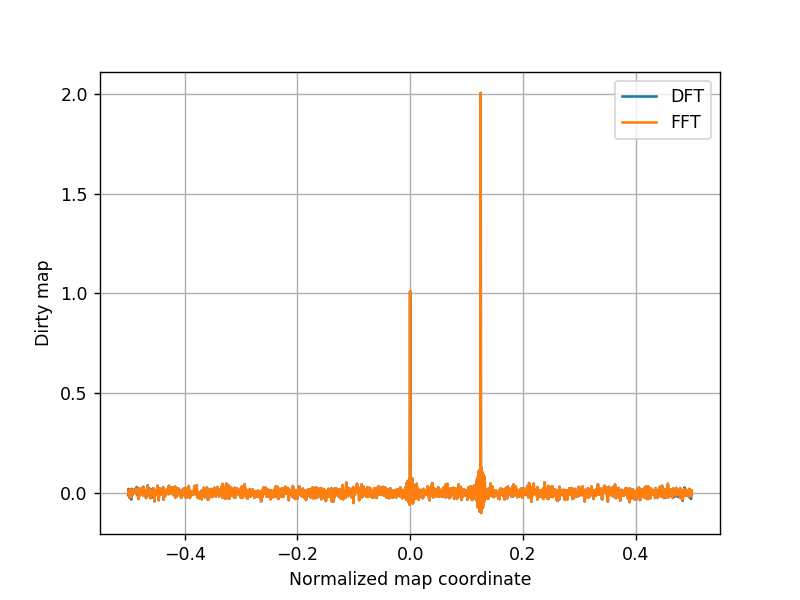

<IPython.core.display.Javascript object>


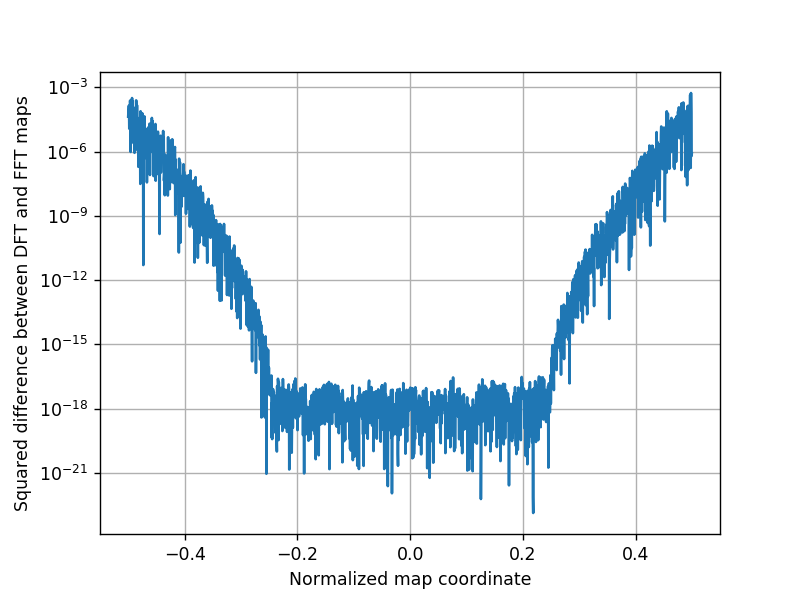

Text(0, 0.5, 'Squared difference between DFT and FFT maps')

In [10]:
# Plot the dirty maps and the square of their difference
plt.figure()
plt.plot(x, D_DFT, label='DFT')
plt.plot(x, D_FFT, label='FFT')
plt.grid(True)
plt.legend()
plt.xlabel('Normalized map coordinate')
plt.ylabel('Dirty map')
plt.figure()
plt.semilogy(x, (D_DFT-D_FFT)**2)
plt.grid(True)
plt.xlabel('Normalized map coordinate')
plt.ylabel('Squared difference between DFT and FFT maps')

## Theoretical bound and typical difference between DFT and FFT maps

We see that the squared difference between the DFT and FFT maps is small within the range of normalized map coordinates $|x|\leq 0.25$ as expected, since the optimization was carried out over this range. Outside that range, the difference increases towards the edge of the map.

In the paper, we derive the following upper bound based on the Cauchy-Schwarz inequality for the squared difference between $D_\text{DFT}$ and $D_\text{FFT}$:

\[ |D_\text{DFT}(x) - D_\text{FFT}(x)|^2 \leq \left(\sum_i w_i |\mathcal{V}_i|^2\right) \ell(x) \label{CS-bound}\]  

where $\ell(x)$ is called the **map error**, which can be expressed in terms of the gridding convolution and correction 
functions,

\[ \ell(x) = \int_0^1\mathrm{d}\nu\, \left|1 - h(x)\sum_r C(r-\nu)\exp[\mathrm{i}2\pi(r-\nu)x] \right|^2 \]

the sum over $r$ being taken over integers satisfying $|r-\nu|<W/2$. Within the `algorithms\core.py` file, there are functions provided to calculate $\ell(x)$ which will be described in more detail in subsequent notebooks. For the moment, the following code snippet calculates the bound in (\ref{CS-bound}) and plots it as the black curve on the same axes as $|D_\text{DFT}(x) - D_\text{FFT}(x)|^2$

<IPython.core.display.Javascript object>


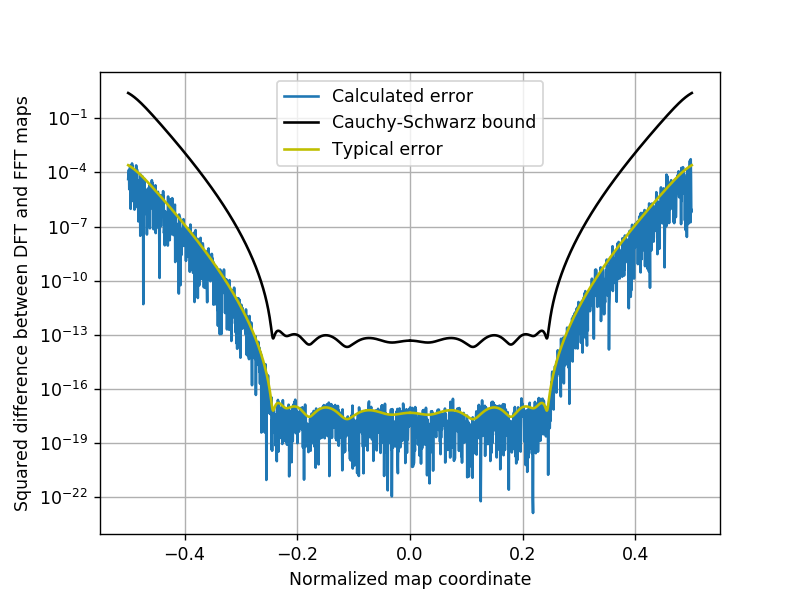

In [11]:
from algorithms.core import make_evaluation_grids, calc_gridder, gridder_to_grid_correction, calc_map_error

nu, x1 = make_evaluation_grids(opt_func.W, opt_func.M, N)
gridder = calc_gridder(opt_func.h, opt_func.x0, nu, opt_func.W)
grid_correction_opt = gridder_to_grid_correction(gridder, nu, x1, opt_func.W)
map_err = calc_map_error(gridder, grid_correction_opt, nu, x1, opt_func.W)

scale_CS = np.sum(w*abs(V)**2)  # Factor to apply to map error to give Cauchy Schwarz bound on squared difference
scale_RND = np.sum(w**2)*sum(abs(V)**2)/Nvis  # Factor to apply to map error to give squared difference for "typical" data

plt.figure()
plt.semilogy(x, abs(D_DFT-D_FFT)**2, label='Calculated error')
plt.semilogy(x1, map_err*scale_CS, 'k', label='_nolegend_')
plt.semilogy(-x1, map_err*scale_CS, 'k', label='Cauchy-Schwarz bound')  
plt.semilogy(x1, map_err*scale_RND, 'y', label='_nolegend_')
plt.semilogy(-x1, map_err*scale_RND, 'y', label='Typical error')
plt.xlabel('Normalized map coordinate')
plt.ylabel('Squared difference between DFT and FFT maps')
plt.legend()
plt.grid(True)

It is apparent that the Cauchy-Schwarz upper bound is substantially larger than the actual calculated error from the simulated data set. If instead of calculating a strict upper bound which holds for any set of visibilities, we ask for a "typical" value of the error based on the assumption that the visibilities are independent random variables, we can derive the orange line shown in the graph which is also proportional to $\ell(x)$ but which more closely approximates the calculated error.

## Exercises:

Go back to the second cell in the section entitled "Mapping using synthetic data" and change the fluxes and locations of the sources using values of your own choosing, or uncomment the code which generates a random set of parameters for `Nsrc` sources.
Then re-execute all the following cells.

Repeat the above, uncommenting the lines which generate Gaussian distributed random complex visibilities rather than a collection of point sources.

Repeat the above using different weights for the visibilities. These must still be non-negative and sum to one.

You should find that in all of the examples, the Cauchy-Schwarz bound lies considerably above the actual squared difference $|D_\text{DFT}(x) - D_\text{FFT}(x)|^2$ and that the "typical error" is much close to the actual error.

### "Adversarial" visibilities

We next demonstrate that even though the actual error usually lies close to the predicted typical error and is considerably less than the Cauchy-Schwarz bound, it is possible to craft the set of visibilities so that the error actually reaches the bound at a specific value of $x$. Run the following cell and then go back and uncomment the line which generates the visibilities by calling the `adversarial_vis` function. After re-running the analysis, you should find that the error at $x=0$ does reach the Cauchy-Schwarz bound, although the errors at other values of $x$ remain close to the "typical error"

In [12]:
def adversarial_vis(u):
    V = np.zeros(u.shape, dtype=complex)
    for i in range(Nvis):
        locations, conv_func = get_grid_weights(lookup, u[i])
        V[i] = (1 - np.sum(conv_func))
    return V/sum(V)

## Plotting the Least-Misfit Gridding Convolution and Correction Functions

When actually carrying out convolutional gridding, it is necessary to take a visibility point at a specific coordinate $u_i$ and use this to update the $W$ points in the FFT grid with integer coordinates $r$, where $r$ satisfies $-W/2<r-u_i\leq W/2$. The function `get_grid_weights` effectively uses the Newton forward-difference algorithm to interpolate these values from $W$ lookup tables and it is the recommended way of calculating these values. It is almost never necessary to work with the gridding function itself defined on the interval ${-W/2, W/2]$ unless one wishes to plot it. For this purpose the function `get_gridder` is provided. In the code below, the optimal gridding correction function is shown together with the reciprocal of the Fourier transform of the gridding convolution function. These differ significantly only near the edges of the map.    

<IPython.core.display.Javascript object>


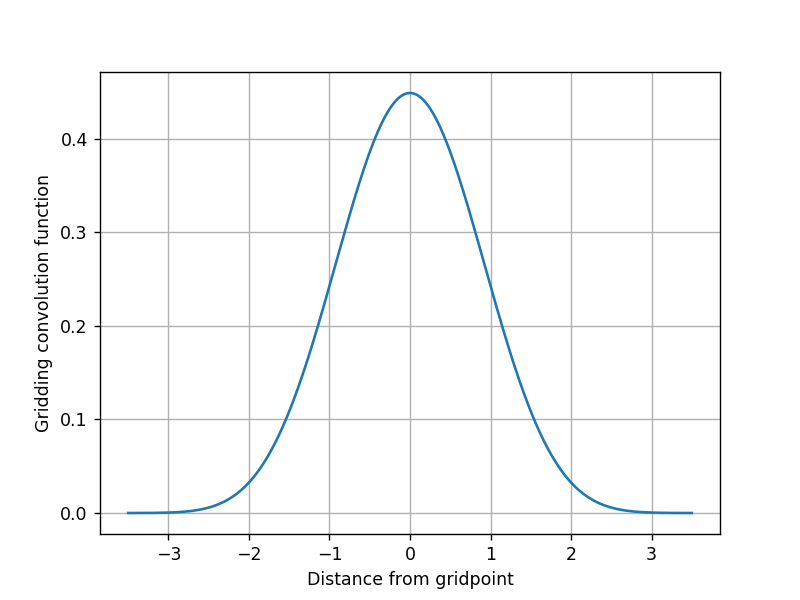

<IPython.core.display.Javascript object>


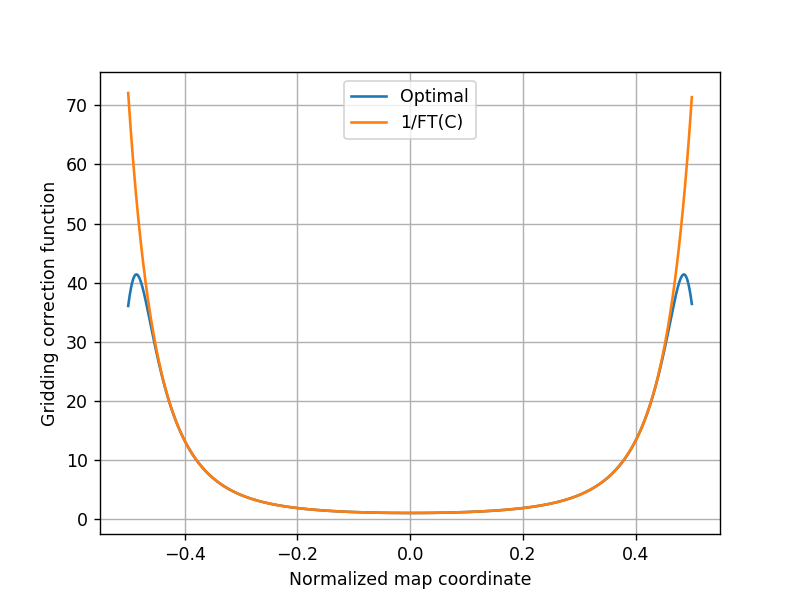

In [13]:
N = 2048
nu_vals = np.linspace(-opt_func.W/2, opt_func.W/2, 16384)
C = np.asarray([get_gridder(lookup, nu) for nu in nu_vals])

plt.figure()
plt.plot(nu_vals, C)
plt.grid(True)
plt.xlabel("Distance from gridpoint")
plt.ylabel("Gridding convolution function")

x = np.arange(-N/2, N/2)/N
correction1 = get_grid_correction(opt_func, x, optimal=True)
correction2 = get_grid_correction(opt_func, x, optimal=False)

plt.figure()
plt.plot(x, correction1, label='Optimal')
plt.plot(x, correction2, label='1/FT(C)')
plt.grid(True)
plt.xlabel("Normalized map coordinate")
plt.ylabel("Gridding correction function")
plt.legend()